<a href="https://colab.research.google.com/github/CamiloRios11/Senalesysistemas/blob/main/Parcial_2%20-%20Luis%20Camilo%20R%C3%ADos%20Mestra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parcial 2:


**Pregunta 1:**
Encuentre la funcion de transferencia en lazo abierto que caracteriza
el sistema masa, resorte, amortiguador, presentado
en la siguiente Figura (asuma condiciones iniciales cero):

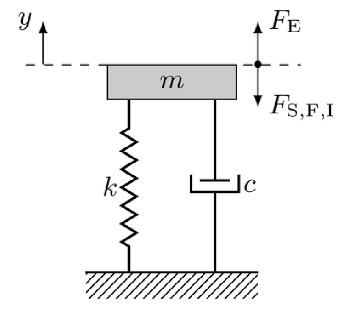

Posteriormente, encuentre el sistema equivalente del modelo
masa, resorte, amortiguador, a partir del siguiente circuito
electrico:

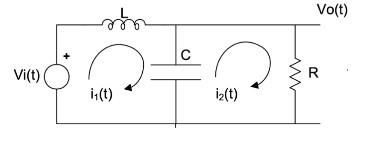

Utilizando la herramienta Streamlit, desarrolle un panel interactivo
(dashboard) para la simulacion de los sistemas estudiados.
El usuario podra seleccionar el tipo de respuesta
del sistema (subamortiguada, sobreamortiguada, con amortiguamiento
crıtico o inestable), ası como ajustar el valor del
factor de amortiguamiento (restringido segun el tipo de respuesta)
y la frecuencia natural.
El dashboard debera visualizar (en configuracion lazo abierto
y lazo cerrado): el diagrama de Bode, el diagrama de polos
y ceros, las respuestas al impulso, al escalon y a la rampa, ası
como los siguientes parametros temporales: tiempo de levantamiento,
sobre-impulso maximo, tiempo en el que ocurre el
sobre-impulso, y tiempo de establecimiento. Tambien, deber
a mostrar los valores estimados de los componentes de
los sistemas (masa, resorte, amortiguador y R, L, C).

**SOLUCION:**

In [1]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.5 MB/s eta 0:00:00


In [2]:
!mkdir pages

In [3]:
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 10.6 MB/s eta 0:00:00


In [4]:
%%writefile 0_👋_Hello.py


import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import control as ct # Una librería de sistemas de control más robusta si es necesaria, pero scipy.signal suele ser suficiente

# --- Funciones Auxiliares para Cálculos ---

def calculate_mkc(omega_n, zeta):
    # Asumimos m=1 por simplicidad para encontrar k y c.
    # De: omega_n = sqrt(k/m), zeta = c / (2 * sqrt(m*k))
    # Si m=1, entonces k = omega_n^2
    # c = 2 * zeta * sqrt(m*k) = 2 * zeta * sqrt(1 * omega_n^2) = 2 * zeta * omega_n
    m = 1.0 # Asignamos arbitrariamente la masa a 1 para la estimación de componentes
    k = omega_n**2 * m
    c = 2 * zeta * omega_n * m
    return m, k, c

def calculate_rlc(omega_n, zeta):
    # Asumimos R=1 por simplicidad para encontrar L y C.
    # De: omega_n = 1/sqrt(LC), zeta = (1/2R) * sqrt(L/C)
    # C = 1 / (omega_n^2 * L)
    # zeta = (1/2R) * sqrt(L / (1/(omega_n^2 * L))) = (1/2R) * sqrt(L^2 * omega_n^2) = (1/2R) * L * omega_n
    # Así, L = 2 * zeta * R / omega_n
    R = 1.0 # Asignamos arbitrariamente R a 1 para la estimación de componentes
    L = 2 * zeta * R / omega_n
    C = 1 / (omega_n**2 * L)
    return R, L, C

def calculate_temporal_parameters(sys_tf):
    if not isinstance(sys_tf, signal.StateSpace):
        sys_tf = signal.TransferFunction(sys_tf.num, sys_tf.den)

    # Respuesta al escalón para parámetros
    # Ajusta el tiempo de simulación para que sea relevante al sistema
    # Si los polos están muy cerca del origen, el tiempo de establecimiento será largo.
    # Usamos 10 veces el inverso del polo de mayor magnitud para tener un tiempo adecuado.
    if len(sys_tf.poles) > 0 and np.max(np.abs(sys_tf.poles)) > 0:
        t_end = 10 / np.max(np.abs(sys_tf.poles))
    else:
        t_end = 10 # Tiempo por defecto si no hay polos o si están en el origen

    t = np.linspace(0, t_end * 2, 500) # Duplicamos el tiempo para asegurar establecimiento

    if len(sys_tf.den) == 0 or (len(sys_tf.num) == 0 and len(sys_tf.den) > 0): # Check for invalid TF
        return np.nan, np.nan, np.nan, np.nan, np.nan # Return NaN if system is invalid or numerator is empty

    try:
        _, y = signal.step(sys_tf, T=t)
    except ValueError: # Handle cases where scipy.signal might fail (e.g., extremely unstable)
        return np.nan, np.nan, np.nan, np.nan, np.nan

    final_value = y[-1] if len(y) > 0 else 0

    # Manejar casos donde el sistema es inestable o no se comporta bien
    if np.any(np.real(sys_tf.poles) > 0) or final_value == 0:
        # Si es inestable y la respuesta diverge, o si el valor final es cero (e.g., sistema integrador puro)
        if np.max(np.abs(y)) > 1e10: # Check for very large values indicating divergence
             return np.nan, np.nan, np.nan, np.nan, np.nan # Unstable, diverging
        if final_value == 0 and np.all(np.abs(y) < 1e-6): # If response is effectively zero
            return np.nan, np.nan, np.nan, np.nan, np.nan
        if np.any(np.real(sys_tf.poles) > 0): # Clearly unstable by poles
             return np.nan, np.nan, np.nan, np.nan, np.nan

    # Si el sistema es subamortiguado, calculamos los parámetros relevantes
    if 0 < zeta_value < 1:
        # Tiempo de Levantamiento (10% a 90%)
        idx_10 = np.where(y >= 0.1 * final_value)[0]
        idx_90 = np.where(y >= 0.9 * final_value)[0]
        tr = t[idx_90[0]] - t[idx_10[0]] if len(idx_10) > 0 and len(idx_90) > 0 else np.nan

        # Tiempo Pico y Máximo Sobreimpulso
        if np.max(y) > final_value:
            peak_idx = np.argmax(y)
            tp = t[peak_idx]
            mp_value = y[peak_idx]
            Mp = ((mp_value - final_value) / final_value) * 100 if final_value != 0 else np.inf
        else:
            tp = np.nan
            Mp = 0 # No hay sobreimpulso
    else: # Para sistemas no subamortiguados, estos parámetros pueden no ser significativos
        tr, tp, Mp = np.nan, np.nan, 0

    # Tiempo de Establecimiento (criterio del 2%)
    # Encuentra el tiempo cuando la respuesta permanece dentro de +/- 2% del valor final
    settling_band_upper = final_value * 1.02
    settling_band_lower = final_value * 0.98

    ts = np.nan
    # Find the first time point where the response enters the band
    start_settling_idx = -1
    for i in range(len(t)):
        if settling_band_lower <= y[i] <= settling_band_upper:
            if start_settling_idx == -1: # First time we enter the band
                start_settling_idx = i
        elif start_settling_idx != -1: # If we were in the band and now out
            start_settling_idx = -1 # Reset, need to find a new start

    if start_settling_idx != -1: # If we found a segment where it's in the band
        # Check if it stays in the band until the end of the simulation
        if np.all((y[start_settling_idx:] >= settling_band_lower) & (y[start_settling_idx:] <= settling_band_upper)):
            ts = t[start_settling_idx]

    # Fallback for systems that quickly settle (e.g. critically damped)
    if np.isnan(ts) and zeta_value >= 1:
        ts = 4 / (zeta_value * omega_n) if (zeta_value * omega_n) != 0 else np.nan


    return tr, tp, Mp, ts, final_value

# --- UI de Streamlit ---

st.set_page_config(layout="wide", page_title="Dashboard de Sistemas de Control")

st.title("Simulador Interactivo de Sistemas de Control (2do Orden)")

# Sidebar para controles
st.sidebar.header("Configuración del Sistema")

system_type = st.sidebar.selectbox(
    "Seleccione el Tipo de Sistema:",
    ("Masa-Resorte-Amortiguador", "Circuito RLC")
)

response_type = st.sidebar.selectbox(
    "Tipo de Respuesta Deseada:",
    ("Subamortiguada", "Criticamente Amortiguada", "Sobreamortiguada", "Amortiguación Cero", "Inestable")
)

st.sidebar.markdown("---")
st.sidebar.header("Parámetros del Sistema")

# Deslizador dinámico para Zeta basado en response_type
zeta_min_slider = 0.0
zeta_max_slider = 2.0
zeta_default_value = 0.5

if response_type == "Subamortiguada":
    zeta_min_slider = 0.01
    zeta_max_slider = 0.99
    zeta_default_value = 0.5
elif response_type == "Criticamente Amortiguada":
    zeta_min_slider = 1.0
    zeta_max_slider = 1.0 # Bloqueado en 1
    zeta_default_value = 1.0
elif response_type == "Sobreamortiguada":
    zeta_min_slider = 1.01
    zeta_max_slider = 5.0
    zeta_default_value = 1.5
elif response_type == "Inestable":
    zeta_min_slider = -2.0
    zeta_max_slider = -0.01
    zeta_default_value = -0.5
elif response_type == "Amortiguación Cero":
    zeta_min_slider = 0.0
    zeta_max_slider = 0.0 # Bloqueado en 0
    zeta_default_value = 0.0

zeta_value = st.sidebar.slider("Factor de Amortiguamiento ($\zeta$)", zeta_min_slider, zeta_max_slider, zeta_default_value, step=0.01, format="%.2f")
omega_n = st.sidebar.slider("Frecuencia Natural ($\omega_n$ rad/s)", 0.1, 20.0, 5.0, step=0.1, format="%.2f")

st.sidebar.markdown("---")
system_config = st.sidebar.radio(
    "Configuración del Lazo:",
    ("Lazo Abierto", "Lazo Cerrado")
)

# --- Definición del Sistema ---
# Numerador y Denominador para la forma estándar del sistema de 2do orden
# H(s) = omega_n^2 / (s^2 + 2*zeta*omega_n*s + omega_n^2)
numerator = [omega_n**2]
denominator = [1, 2 * zeta_value * omega_n, omega_n**2]

if system_config == "Lazo Cerrado":
    # Para un sistema con retroalimentación unitaria, H_cl(s) = G(s) / (1 + G(s))
    # Si G(s) = num/den, entonces H_cl(s) = (num/den) / (1 + num/den) = num / (den + num)
    # Nuestro G(s) es omega_n^2 / (s^2 + 2*zeta*omega_n*s + omega_n^2)
    # Entonces, num_cl = numerator
    # den_cl = denominator + numerator
    den_closed_loop_coeffs = np.polyadd(denominator, numerator)
    sys_tf = signal.TransferFunction(numerator, den_closed_loop_coeffs)
else: # Lazo Abierto
    sys_tf = signal.TransferFunction(numerator, denominator)

# --- Mostrar Información del Sistema ---
st.header("Información del Sistema")

col1, col2 = st.columns(2)

with col1:
    st.subheader("Componentes Estimados")
    if system_type == "Masa-Resorte-Amortiguador":
        m, k, c = calculate_mkc(omega_n, zeta_value)
        st.write(f"Masa (m): {m:.2f} kg (asumido)")
        st.write(f"Constante del Resorte (k): {k:.2f} N/m")
        st.write(f"Coeficiente de Amortiguamiento (c): {c:.2f} Ns/m")
    else: # Circuito RLC
        R, L, C = calculate_rlc(omega_n, zeta_value)
        st.write(f"Resistencia (R): {R:.2f} Ω (asumido)")
        st.write(f"Inductancia (L): {L:.2e} H")
        st.write(f"Capacitancia (C): {C:.2e} F")

with col2:
    st.subheader("Función de Transferencia")
    # Limpiar los coeficientes para evitar problemas de visualización con números muy pequeños
    num_coeffs = [float(f"{coeff:.2f}") for coeff in sys_tf.num]
    den_coeffs = [float(f"{coeff:.2f}") for coeff in sys_tf.den]

    # Convertir a objetos Poly1d para una representación LaTeX más limpia
    num_poly = np.poly1d(num_coeffs)
    den_poly = np.poly1d(den_coeffs)

    st.latex(f"G(s) = \\frac{{{num_poly}}}{{{den_poly}}}")
    st.write(f"Frecuencia Natural ($\omega_n$): {omega_n:.2f} rad/s")
    st.write(f"Factor de Amortiguamiento ($\zeta$): {zeta_value:.2f}")

# --- Sección de Gráficos ---
st.header("Análisis de Respuesta del Sistema")

tab1, tab2, tab3, tab4, tab5 = st.tabs(["Diagrama de Bode", "Mapa de Polos y Ceros", "Respuesta al Impulso", "Respuesta al Escalón", "Respuesta a la Rampa"])

# Generar gráficos
# Asegurarse de que el sistema sea válido antes de intentar plotear
if len(sys_tf.num) == 0 or len(sys_tf.den) == 0 or np.all(sys_tf.den == 0):
    st.error("La función de transferencia no es válida para la combinación de parámetros actual. Por favor, ajuste $\omega_n$ y $\zeta$.")
else:
    with tab1:
        st.subheader("Diagrama de Bode")
        fig_bode, ax_bode = plt.subplots(2, 1, figsize=(10, 8))
        omega, mag, phase = signal.bode(sys_tf)

        ax_bode[0].semilogx(omega, mag)
        ax_bode[0].set_ylabel('Magnitud (dB)')
        ax_bode[0].grid(True, which="both", ls="-")
        ax_bode[0].set_title('Diagrama de Magnitud')

        ax_bode[1].semilogx(omega, phase)
        ax_bode[1].set_xlabel('Frecuencia (rad/s)')
        ax_bode[1].set_ylabel('Fase (grados)')
        ax_bode[1].grid(True, which="both", ls="-")
        ax_bode[1].set_title('Diagrama de Fase')

        plt.tight_layout()
        st.pyplot(fig_bode)

    with tab2:
        st.subheader("Mapa de Polos y Ceros")
        fig_pz, ax_pz = plt.subplots(figsize=(6, 6))
        poles = sys_tf.poles
        zeros = sys_tf.zeros

        # Plotear polos (x)
        ax_pz.plot(np.real(poles), np.imag(poles), 'rx', markersize=10, label='Polos')
        # Plotear ceros (o)
        ax_pz.plot(np.real(zeros), np.imag(zeros), 'bo', markersize=10, label='Ceros')

        # Añadir etiquetas y rejilla
        ax_pz.axvline(0, color='grey', linestyle='--', linewidth=0.8)
        ax_pz.axhline(0, color='grey', linestyle='--', linewidth=0.8)
        ax_pz.set_xlabel('Parte Real')
        ax_pz.set_ylabel('Parte Imaginaria')
        ax_pz.set_title('Mapa de Polos y Ceros')
        ax_pz.grid(True)
        ax_pz.legend()
        # Ajustar límites para mostrar el origen claramente
        # Considerar el valor absoluto máximo de polos y ceros
        all_roots = np.concatenate((poles, zeros))
        if len(all_roots) > 0:
            max_abs_val = np.max(np.abs(all_roots))
            if max_abs_val > 0:
                plot_limit = max_abs_val * 1.2
            else:
                plot_limit = 1.2 # Default if all roots are at origin
        else:
            plot_limit = 1.2 # Default if no roots

        ax_pz.set_xlim([-plot_limit, plot_limit])
        ax_pz.set_ylim([-plot_limit, plot_limit])
        ax_pz.set_aspect('equal', adjustable='box') # Hacer ejes iguales para mejor visualización

        st.pyplot(fig_pz)

    # Gráficos de dominio del tiempo
    # Ajustar el lapso de tiempo dinámicamente.
    # El tiempo final de simulación se basa en los polos.
    if len(sys_tf.poles) > 0 and np.max(np.abs(sys_tf.poles)) > 0:
        # Si el polo real más grande es positivo (sistema inestable), el tiempo debe ser pequeño
        # Si el polo real más grande es negativo (sistema estable), el tiempo debe ser suficiente para que se asiente
        max_abs_pole_real = np.max(np.abs(np.real(sys_tf.poles)))
        if max_abs_pole_real == 0: # Purely imaginary poles or poles at origin
            t_end_sim = 10 / omega_n * 2 # Use natural frequency for oscillation period
        else:
            t_end_sim = 8 / max_abs_pole_real # Usually 4-5 time constants for settling (for 2% criterion)
            if zeta_value < 0.1 and omega_n > 0: # Very underdamped, ensure enough oscillations
                 t_end_sim = max(t_end_sim, 2 * np.pi / omega_n * 5) # At least 5 periods

        if zeta_value < 0: # Unstable system
             t_end_sim = 5 / omega_n # Keep time shorter to avoid huge numbers
    else:
        t_end_sim = 10 / omega_n # Default if no poles

    t = np.linspace(0, t_end_sim, 500)

    with tab3:
        st.subheader("Respuesta al Impulso")
        fig_impulse, ax_impulse = plt.subplots(figsize=(10, 6))
        tout_impulse, yout_impulse = signal.impulse(sys_tf, T=t)
        ax_impulse.plot(tout_impulse, yout_impulse)
        ax_impulse.set_xlabel('Tiempo (s)')
        ax_impulse.set_ylabel('Amplitud')
        ax_impulse.set_title('Respuesta al Impulso')
        ax_impulse.grid(True)
        st.pyplot(fig_impulse)

    with tab4:
        st.subheader("Respuesta al Escalón")
        fig_step, ax_step = plt.subplots(figsize=(10, 6))
        tout_step, yout_step = signal.step(sys_tf, T=t)
        ax_step.plot(tout_step, yout_step)
        ax_step.set_xlabel('Tiempo (s)')
        ax_step.set_ylabel('Amplitud')
        ax_step.set_title('Respuesta al Escalón')
        ax_step.grid(True)
        st.pyplot(fig_step)

    with tab5:
        st.subheader("Respuesta a la Rampa")
        fig_ramp, ax_ramp = plt.subplots(figsize=(10, 6))
        # La respuesta a la rampa es la integral de la respuesta al escalón.
        # Se puede obtener aplicando una entrada de rampa unitaria.
        ramp_input = t # Rampa unitaria
        tout_ramp, yout_ramp, _ = signal.lsim(sys_tf, ramp_input, t)
        ax_ramp.plot(tout_ramp, yout_ramp)
        ax_ramp.plot(t, t, 'k--', label='Entrada Rampa Ideal') # Plot ideal ramp for comparison
        ax_ramp.set_xlabel('Tiempo (s)')
        ax_ramp.set_ylabel('Amplitud')
        ax_ramp.set_title('Respuesta a la Rampa')
        ax_ramp.grid(True)
        ax_ramp.legend()
        st.pyplot(fig_ramp)

# --- Mostrar Parámetros Temporales ---
st.header("Parámetros Temporales (Respuesta al Escalón)")

tr, tp, Mp, ts, final_value_step = calculate_temporal_parameters(sys_tf)

col3, col4 = st.columns(2)

with col3:
    st.write(f"Tiempo de Levantamiento (tr): {'{:.3f} s'.format(tr) if not np.isnan(tr) else 'N/A'}")
    st.write(f"Tiempo Pico (tp): {'{:.3f} s'.format(tp) if not np.isnan(tp) else 'N/A'}")

with col4:
    st.write(f"Sobre-impulso Máximo (Mp): {'{:.2f} %'.format(Mp) if not np.isnan(Mp) else 'N/A'}")
    st.write(f"Tiempo de Establecimiento (ts, 2%): {'{:.3f} s'.format(ts) if not np.isnan(ts) else 'N/A'}")

if response_type == "Sobreamortiguada" or response_type == "Criticamente Amortiguada" or response_type == "Amortiguación Cero":
    st.info("Nota: Los parámetros de sobre-impulso máximo y tiempo pico son más relevantes para sistemas subamortiguados. Para este tipo de sistema, suelen ser 0 o no aplicables.")
elif response_type == "Inestable":
     st.warning("Advertencia: El sistema es inestable. Los parámetros temporales pueden no ser significativos y la respuesta puede divergir.")

st.markdown("---")
st.markdown("Desarrollado con Streamlit y SciPy.")

Writing 0_👋_Hello.py


In [7]:
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
!mv cloudflared-linux-amd64 /usr/local/bin/cloudflared

#Ejecutar Streamlit
!streamlit run 0_👋_Hello.py &>/content/logs.txt & #Cambiar 0_👋_Hello.py por el nombre de tu archivo principal

#Exponer el puerto 8501 con Cloudflare Tunnel
!cloudflared tunnel --url http://localhost:8501 > /content/cloudflared.log 2>&1 &

#Leer la URL pública generada por Cloudflare
import time
time.sleep(5)  # Esperar que se genere la URL

import re
found_context = False  # Indicador para saber si estamos en la sección correcta

with open('/content/cloudflared.log') as f:
    for line in f:
        #Detecta el inicio del contexto que nos interesa
        if "Your quick Tunnel has been created" in line:
            found_context = True

        #Busca una URL si ya se encontró el contexto relevante
        if found_context:
            match = re.search(r'https?://\S+', line)
            if match:
                url = match.group(0)  #Extrae la URL encontrada
                print(f'Tu aplicación está disponible en: {url}')
                break  #Termina el bucle después de encontrar la URL

--2025-07-08 14:54:08--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... ^C
chmod: cannot access 'cloudflared-linux-amd64': No such file or directory
mv: cannot stat 'cloudflared-linux-amd64': No such file or directory
Tu aplicación está disponible en: https://appliances-agencies-va-locks.trycloudflare.com


In [8]:
import os

res = input("Digite (1) para finalizar la ejecución del Dashboard: ")

if res.upper() == "1":
    os.system("pkill streamlit")  # Termina el proceso de Streamlit
    print("El proceso de Streamlit ha sido finalizado.")


Digite (1) para finalizar la ejecución del Dashboard: 1
El proceso de Streamlit ha sido finalizado.


**Pregunta 2:**
Consulte y presente el modelo matematico del proceso de
modulacion y demodulacion por amplitud en banda lateral
unica (SSB-AM), tanto en el dominio del tiempo como en
el dominio de la frecuencia (mediante la transformada de
Fourier).
A partir de este modelo, construya un dashboard interactivo
sobre Streamlit que permita al usuario visualizar y comprender
el proceso de modulacion y demodulacion SSB-AM. Para
ello, utilice como señal mensaje:

i) una señal pulso rectangular

ii) un segmento de 5 segundos de una cancion.


Implemente los filtros requeridos en el sistema SSB-AM utilizando
filtros digitales recursivos (IIR), y visualice su comportamiento
mediante el diagrama de Bode y el plano de polos
y ceros. El dashboard debe describir de forma concreta y
clara, cada una de las etapas del proceso, presentado graficas
relevantes de las señales obtenidas en etapas intermedias en
el tiempo y la frecuencia.

**SOLUCION:**


La Modulación por Amplitud en Banda Lateral Única (SSB-AM o SSB-SC por "Suppressed Carrier") es una técnica de modulación de amplitud que optimiza la eficiencia espectral y de potencia. A diferencia de la modulación de amplitud de doble banda lateral con portadora suprimida (DSB-SC), la SSB-AM transmite únicamente una de las bandas laterales (superior o inferior), eliminando la otra banda lateral y la portadora. Esto resulta en una reducción a la mitad del ancho de banda requerido y una concentración de toda la potencia de transmisión en la información útil.

La generación y demodulación de una señal SSB se basan fundamentalmente en el concepto de la "Transformada de Hilbert".

**Definición de la Transformada de Hilbert:**

Sea $m(t)$ una señal de mensaje en banda base. Su Transformada de Hilbert, denotada como $\hat{m}(t)$, se define en el dominio del tiempo como la convolución de $m(t)$ con $1/(\pi t)$:

$$ \hat{m}(t) = m(t) * \frac{1}{\pi t} = \frac{1}{\pi} \int_{-\infty}^{\infty} \frac{m(\tau)}{t-\tau} d\tau $$

En el dominio de la frecuencia, si $M(f)$ es la Transformada de Fourier de $m(t)$, entonces la Transformada de Fourier de $\hat{m}(t)$, denotada como $\hat{M}(f)$, es:

$$ \hat{M}(f) = -j \text{sgn}(f) M(f) $$

Donde $\text{sgn}(f)$ es la función signo:

$$ \text{sgn}(f) = \begin{cases} 1 & \text{si } f > 0 \\ 0 & \text{si } f = 0 \\ -1 & \text{si } f < 0 \end{cases} $$

Esta relación implica que la Transformada de Hilbert introduce un desfase de $-90^\circ$ (o $-\pi/2$ radianes) a las componentes de frecuencia positivas de $M(f)$ y un desfase de $+90^\circ$ (o $+\pi/2$ radianes) a las componentes de frecuencia negativas de $M(f)$, sin alterar sus magnitudes.

**Modelo Matemático de la Modulación SSB-AM:**

Sea $m(t)$ la señal de mensaje y $c(t) = A_c \cos(2\pi f_c t)$ la señal portadora, donde $A_c$ es la amplitud de la portadora y $f_c$ es la frecuencia de la portadora.

*En el Dominio del Tiempo:*

La señal modulada SSB, $s_{SSB}(t)$, se puede expresar utilizando la señal de mensaje $m(t)$ y su Transformada de Hilbert $\hat{m}(t)$, en combinación con las componentes en fase y en cuadratura de la portadora. Este es el principio del "método de fase" para la generación de SSB.

Banda Lateral Superior (USB - Upper Sideband):

  $$ s_{USB}(t) = A_c [m(t) \cos(2\pi f_c t) - \hat{m}(t) \sin(2\pi f_c t)] $$

Banda Lateral Inferior (LSB - Lower Sideband):

  $$ s_{LSB}(t) = A_c [m(t) \cos(2\pi f_c t) + \hat{m}(t) \sin(2\pi f_c t)] $$

Estas expresiones demuestran que la generación de SSB mediante el método de fase requiere un multiplicador, un desfasador de $90^\circ$ (realizado por la Transformada de Hilbert) y un sumador/restador.

*En el Dominio de la Frecuencia:*

Sea $M(f)$ la Transformada de Fourier de $m(t)$. La Transformada de Fourier de la portadora $A_c \cos(2\pi f_c t)$ es $\frac{A_c}{2} [\delta(f - f_c) + \delta(f + f_c)]$.

La multiplicación en el dominio del tiempo se traduce en una convolución en el dominio de la frecuencia.

Espectro de la Banda Lateral Superior (USB):
   El espectro de la señal SSB-USB, $S_{USB}(f)$, se obtiene a partir de la expresión en el dominio del tiempo:

   $$ S_{USB}(f) = \mathcal{F}\{A_c m(t) \cos(2\pi f_c t)\} - \mathcal{F}\{A_c \hat{m}(t) \sin(2\pi f_c t)\} $$

  Sustituyendo las transformadas de Fourier conocidas:

  $$ S_{USB}(f) = \frac{A_c}{2} [M(f - f_c) + M(f + f_c)] - \frac{A_c}{2j} [\hat{M}(f - f_c) - \hat{M}(f + f_c)] $$

  Utilizando $\hat{M}(f) = -j \text{sgn}(f) M(f)$:

  $$ S_{USB}(f) = \frac{A_c}{2} [M(f - f_c) + M(f + f_c)] - \frac{A_c}{2j} [-j \text{sgn}(f-f_c)M(f-f_c) - (-j \text{sgn}(f+f_c)M(f+f_c))] $$
  $$ S_{USB}(f) = \frac{A_c}{2} [M(f - f_c) + M(f + f_c)] - \frac{A_c}{2} [\text{sgn}(f-f_c)M(f-f_c) + \text{sgn}(f+f_c)M(f+f_c)] $$
  $$ S_{USB}(f) = \frac{A_c}{2} [ (1 - \text{sgn}(f-f_c)) M(f - f_c) + (1 - \text{sgn}(f+f_c)) M(f + f_c) ] $$
  
  Esta expresión demuestra la supresión de la banda lateral inferior y la conservación de la banda lateral superior. Para una señal de mensaje con espectro real y simétrico $M(f)$, el espectro resultante es:

  $$ S_{USB}(f) = \begin{cases} A_c M(f - f_c) & \text{si } f > f_c \\ 0 & \text{si } 0 < f < f_c \\ A_c M(f + f_c) & \text{si } f < -f_c \\ 0 & \text{si } -f_c < f < 0 \end{cases} $$
  
  Una forma compacta usando la función escalón unitario $u(x)$ ($1$ para $x>0$, $0$ para $x<0$):

  $$ S_{USB}(f) = A_c [M(f-f_c)u(f-f_c) + M(f+f_c)u(-f-f_c)] $$

  Espectro de la Banda Lateral Inferior (LSB):

  De manera similar, para la LSB:

  $$ S_{LSB}(f) = \mathcal{F}\{A_c m(t) \cos(2\pi f_c t)\} + \mathcal{F}\{A_c \hat{m}(t) \sin(2\pi f_c t)\} $$
  $$ S_{LSB}(f) = \frac{A_c}{2} [ (1 + \text{sgn}(f-f_c)) M(f - f_c) + (1 + \text{sgn}(f+f_c)) M(f + f_c) ] $$

  Para una señal de mensaje con espectro real y simétrico:

  $$ S_{LSB}(f) = \begin{cases} 0 & \text{si } f > f_c \\ A_c M(f - f_c) & \text{si } 0 < f < f_c \\ 0 & \text{si } f < -f_c \\ A_c M(f + f_c) & \text{si } -f_c < f < 0 \end{cases} $$

  Una forma compacta:

  $$ S_{LSB}(f) = A_c [M(f-f_c)u(-(f-f_c)) + M(f+f_c)u(f+f_c)] $$

En resumen, la modulación SSB en el dominio de la frecuencia implica desplazar el espectro de la señal de mensaje a $\pm f_c$ y luego usar un filtro de banda lateral ideal para eliminar una de las bandas laterales.

**Modelo Matemático de la Demodulación SSB-AM:**

La demodulación SSB-AM es un proceso coherente, lo que implica que el receptor debe generar una portadora local que esté perfectamente sincronizada en frecuencia y fase con la portadora utilizada en el transmisor.

Sea $s_{SSB}(t)$ la señal SSB recibida. Para la demodulación, la señal recibida se multiplica por una portadora local $A_r \cos(2\pi f_c t)$ y el resultado se pasa a través de un filtro de paso bajo (LPF). Se asume $A_r = 2$ para recuperar la amplitud original de $m(t)$.

*En el Dominio del Tiempo:*

Sea la portadora local $c_{demod}(t) = 2 A_c \cos(2\pi f_c t)$.


  Demodulación de USB:
  Si la señal recibida es $s_{USB}(t) = A_c [m(t) \cos(2\pi f_c t) - \hat{m}(t) \sin(2\pi f_c t)]$.

  La señal después del multiplicador es $s_{demod}(t)$:

  $$ s_{demod}(t) = s_{USB}(t) \cdot 2 \cos(2\pi f_c t) $$
  $$ s_{demod}(t) = 2 A_c [m(t) \cos(2\pi f_c t) - \hat{m}(t) \sin(2\pi f_c t)] \cos(2\pi f_c t) $$
  $$ s_{demod}(t) = 2 A_c m(t) \cos^2(2\pi f_c t) - 2 A_c \hat{m}(t) \sin(2\pi f_c t) \cos(2\pi f_c t) $$

  Utilizando las identidades trigonométricas $\cos^2(\theta) = \frac{1 + \cos(2\theta)}{2}$ y $\sin(\theta)\cos(\theta) = \frac{1}{2}\sin(2\theta)$:

  $$ s_{demod}(t) = A_c m(t) (1 + \cos(4\pi f_c t)) - A_c \hat{m}(t) \sin(4\pi f_c t) $$
  $$ s_{demod}(t) = A_c m(t) + A_c m(t) \cos(4\pi f_c t) - A_c \hat{m}(t) \sin(4\pi f_c t) $$

   Aplicando un filtro de paso bajo ideal (LPF) que elimina las componentes de alta frecuencia (centradas en $2f_c$), obtenemos la señal demodulada $m_{demod}(t)$:

  $$ m_{demod}(t) = A_c m(t) $$

  Demodulación de LSB:

  Si la señal recibida es $s_{LSB}(t) = A_c [m(t) \cos(2\pi f_c t) + \hat{m}(t) \sin(2\pi f_c t)]$.

  La señal después del multiplicador es $s_{demod}(t)$:

  $$ s_{demod}(t) = s_{LSB}(t) \cdot 2 \cos(2\pi f_c t) $$
  $$ s_{demod}(t) = 2 A_c [m(t) \cos(2\pi f_c t) + \hat{m}(t) \sin(2\pi f_c t)] \cos(2\pi f_c t) $$
  $$ s_{demod}(t) = 2 A_c m(t) \cos^2(2\pi f_c t) + 2 A_c \hat{m}(t) \sin(2\pi f_c t) \cos(2\pi f_c t) $$
  $$ s_{demod}(t) = A_c m(t) (1 + \cos(4\pi f_c t)) + A_c \hat{m}(t) \sin(4\pi f_c t) $$
  $$ s_{demod}(t) = A_c m(t) + A_c m(t) \cos(4\pi f_c t) + A_c \hat{m}(t) \sin(4\pi f_c t) $$
  Aplicando un filtro de paso bajo ideal (LPF):

  $$ m_{demod}(t) = A_c m(t) $$

En ambos casos (USB y LSB), la demodulación coherente con una portadora local correctamente sincronizada y un filtro de paso bajo recupera la señal de mensaje original (escalada por una constante de amplitud).

*En el Dominio de la Frecuencia:*

Sea $S_{SSB}(f)$ el espectro de la señal SSB recibida. La multiplicación en el dominio del tiempo por $2 \cos(2\pi f_c t)$ corresponde a una convolución en el dominio de la frecuencia por la Transformada de Fourier de la portadora local: $[\delta(f - f_c) + \delta(f + f_c)]$.

El espectro de la señal después del multiplicador es $S_{demod}(f)$:

$$ S_{demod}(f) = S_{SSB}(f) * [\delta(f - f_c) + \delta(f + f_c)] $$
$$ S_{demod}(f) = S_{SSB}(f - f_c) + S_{SSB}(f + f_c) $$

Esta operación desplaza el espectro SSB hacia la izquierda por $f_c$ y hacia la derecha por $f_c$. Las componentes espectrales que estaban centradas en $\pm f_c$ ahora se desplazan a $0$ (formando la señal de mensaje recuperada) y a $\pm 2f_c$ (componentes de doble frecuencia).

Finalmente, se aplica un Filtro de Paso Bajo (LPF) ideal con una frecuencia de corte $f_{c_p}$ tal que $f_{max} < f_{c_p} < 2f_c$, donde $f_{max}$ es la máxima frecuencia en la señal de mensaje. Este LPF elimina las componentes de doble frecuencia, dejando solo la señal de mensaje recuperada centrada en $0$ Hz.

$$ M_{demod}(f) = S_{demod}(f) \cdot H_{LPF}(f) $$

Donde $H_{LPF}(f)$ es la respuesta en frecuencia de un filtro de paso bajo ideal.

**Ventajas de SSB-AM:**

Las principales ventajas de la modulación SSB-AM sobre otras modulaciones de amplitud son:

  *Eficiencia de Ancho de Banda: El ancho de banda requerido se reduce a la mitad en comparación con la modulación DSB-AM, es decir, $B_{SSB} = B_m$, donde $B_m$ es el ancho de banda de la señal de mensaje. Esto permite acomodar el doble de canales en el mismo espectro.

  *Eficiencia de Potencia: Toda la potencia de transmisión se concentra en la información de la banda lateral útil, ya que la portadora y la otra banda lateral son suprimidas. Esto conduce a un uso más eficiente de la potencia del transmisor.


**Desventajas de SSB-AM:**

La principal desventaja de SSB-AM es la complejidad inherente a su implementación y operación:

  *Complejidad del Circuito: La generación de SSB requiere circuitos más complejos (por ejemplo, el uso de la Transformada de Hilbert o filtros de banda lateral de alta selectividad).
    
  *Demodulación Coherente: La demodulación requiere una portadora local en el receptor que esté precisa y rígidamente sincronizada en frecuencia y fase con la portadora original del transmisor. Pequeños errores de sincronización pueden causar distorsión severa en la señal demodulada.


Para ejecutar este dashboard entra en el siguiente link:



https://colab.research.google.com/drive/1KdPpyXyfjc-BKdtzyEqgoyfC10wISV8g#scrollTo=7JwnFAzbiDrt